## Goal... test training schemes
Test: Using $ W_{\mathrm{res}}\in\mathbb{R}^{N\times N} $ we take $ N $ steps before getting the loss $ \mathcal{L} $, on $ N+1 $ only, before backprop. This is motivated by work in Chaos paper. The max reservoir memory is $ t-N $ time-steps to predict the next step $ t+1 $.

In [1]:
import sys
sys.path.insert(1,'/home/bwhiteak/exESN/ESN_utils/')
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

import ESN_util.rc_tools as rct
import ESN_util.rc_analysis as rca

from itertools import chain 
from torchviz import make_dot, make_dot_from_trace

import torch
from torch import Tensor
import torch.nn as nn
import torch.optim as optim
from torch.nn.parameter import Parameter
import pdb 
from jupyterthemes import jtplot
jtplot.style()

def grad_printer(model: nn.Module) -> nn.Module:
    for parameter in model.parameters():
        parameter.register_hook(lambda grad: print(f'{grad}'))
    return model

In [2]:
DEV = 'cuda:6'
DTYPE = torch.float32 

In [3]:
K = 1
N = 30
L = 1
TRAIN = 14000

In [20]:
class Pmul(torch.autograd.Function):
    @staticmethod
    def forward(ctx, a, g):
        ctx.save_for_backward(a,g)
        return torch.mul(a,g)

    @staticmethod
    def backward(ctx, grad_output):
        a,g = ctx.saved_tensors
        da = grad_output*g 
        dg = grad_output*a
        return da, dg

class Leaky_Tanh(nn.Module):
    def __init__(self, N):
        """
        Initialize learnable parameters:
        alpha = controls influence of past information
        gamma = controls amplitude from nonlinear term
        """
        super(Leaky_Tanh,self).__init__()
        self.a = Parameter(torch.mul(torch.ones(1,N),.5))
        self.g = Parameter(torch.rand(1,N))
        self.pmul = Pmul.apply
        
    def forward(self, xt, zt):  
        return (1-self.a)*xt + self.pmul(self.a,self.g)*torch.tanh(xt+zt) 
    
class SymESN(nn.Module):
    def __init__(self, k, n, l, r, rho):
        super(SymESN, self).__init__()

        self.N = n
        self.Q, self.d, self.Qt = self.initRes(r, rho)
        self.D = Parameter(self.d)
        self.Rin = nn.Linear(k, self.N, bias=False)
        self.Lky = Leaky_Tanh(self.N)
        self.Rout = nn.Linear(self.N+k,l, bias=False)

    def forward(self, hidden, ut):
        zt = self.Rin(ut)
        print(hidden.size())
        ht = torch.bmm(hidden,torch.bmm(self.Q, torch.bmm(torch.diag(self.D), self.Qt)))#self.Res(hidden)
        ht1 = self.Lky(ht,zt)
        out = self.Rout(torch.cat((ht1,ut),1))
        return ht1, out

    def packState(self, h=None):
        if(not h):
            h = torch.randn(1, self.N)
        else:
            h = h.detach_()
        return h
    def initRes(self, r, rho):
        A = torch.mul(torch.sub(torch.rand((self.N,self.N)),.5),2.)
        W = (A + torch.transpose(A,0,1))-torch.diag(torch.diagonal(A))
        eigmax = torch.max(torch.abs(torch.linalg.eigvals(W)))
        Wszd = torch.mul(torch.div(W,eigmax),rho)
        D,Q = torch.linalg.eig(Wszd)
        D = torch.unsqueeze(D,0)
        Q = torch.unsqueeze(Q,0)
        return torch.real(Q).cuda(DEV), torch.real(D).cuda(DEV), torch.real(torch.transpose(Q,0,1)).cuda(DEV)

esn = SymESN(K,N,L,1.0,.6).float().cuda(DEV)
print(esn)
for n,p in esn.named_parameters():
    print(n)

SymESN(
  (Rin): Linear(in_features=1, out_features=30, bias=False)
  (Lky): Leaky_Tanh()
  (Rout): Linear(in_features=31, out_features=1, bias=False)
)
D
Rin.weight
Lky.a
Lky.g
Rout.weight


In [14]:
l.size()

torch.Size([10, 30])

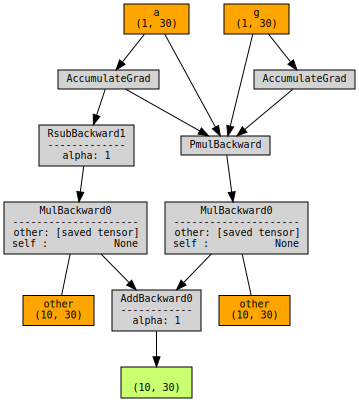

In [5]:
make_dot(l, params=dict(lky.named_parameters()), show_attrs=True, show_saved=True)

In [7]:
#make_dot(yhat, params=dict(esn.named_parameters()), show_attrs=True, show_saved=True)

In [8]:
FREERUN = 20
DT = .02
rho = 28.0
sigma = 10.0
beta = 8/3
BATCH = 3

def f(state, t):
    x,y,z = state
    return sigma*(y-x), x*(rho-z)-y, x*y - beta*z

def  lorenz63(batch, length, delta=.02, x0_range=5):
    arrs = []
    for b in range(batch):
        state0 = np.array([1.,1.,1.])+np.random.randn(3)*x0_range
        t = np.arange(0,length,delta)
        states = odeint(f,state0,t)
        muX = np.mean(states[:], axis=0)
        arrs.append((states-muX).T)
    return np.array(arrs)

#(batch,dim,data_len)
#signal = torch.tensor(states[:TRAIN,0]-muX, device=DEV).float()
        
X = lorenz63(BATCH, 300+FREERUN, .02)
signal = torch.tensor(X[:,0,:])

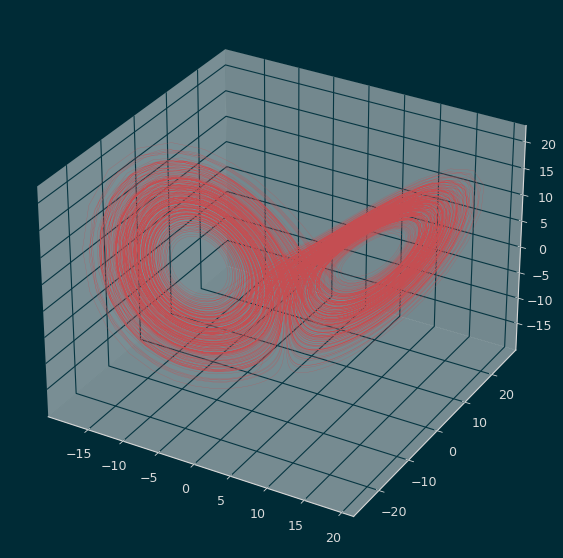

In [9]:
fig3d = plt.figure(figsize=(10,10))
ax3d = plt.axes(projection='3d')
ax3d.plot3D(X[2,0,:], X[2,1,:], X[2,2,:], 'r', linewidth=.2)
plt.show()

In [10]:
criterion = nn.MSELoss()
optimizer = optim.Adam(esn.parameters(),lr=.001)

Epoch: 0
1.6320419819104985
Epoch: 0


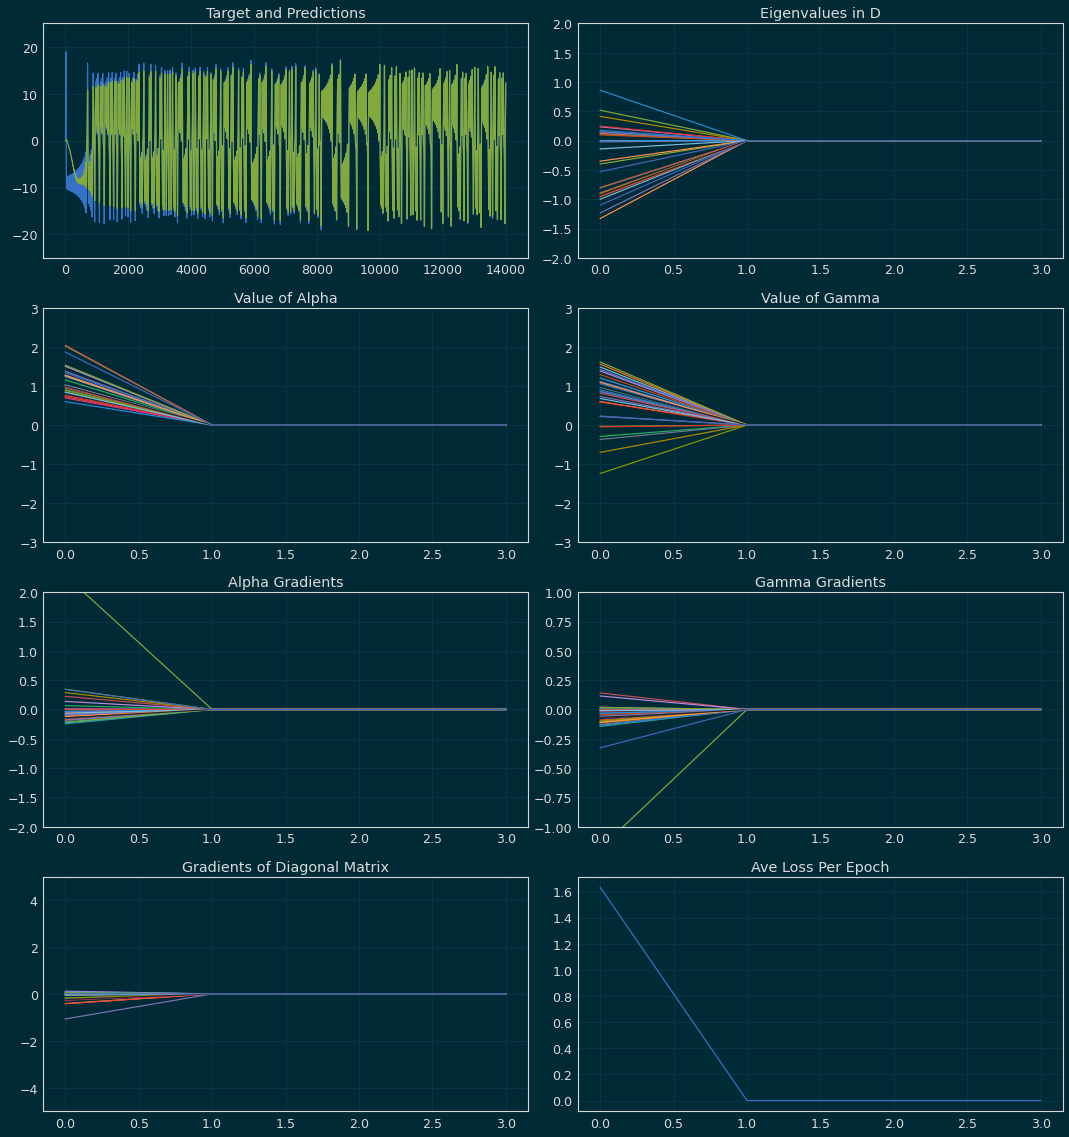

Epoch: 1
0.03435088863152427
Epoch: 2
0.023407739165863344
Epoch: 3
0.017536804433254182


In [10]:
EPOCHS = 4
alphas = np.zeros((EPOCHS,N))
gammas = np.zeros((EPOCHS,N))
Agrad = np.zeros((EPOCHS,N))
Ggrad = np.zeros((EPOCHS,N))
SRgrad = np.zeros((EPOCHS,N))
eigs = np.zeros((EPOCHS,N))
epoch_loss = np.zeros(EPOCHS)
torch.autograd.set_detect_anomaly(True)
for ep in range(EPOCHS):
    print(f'Epoch: {ep}')
    preds = np.zeros(TRAIN)
    xt = esn.packState().cuda(DEV)
    running_loss = 0.
    loss = 0.
    for i in range(TRAIN-N):
        y = signal[i+N].view(1,1)
        optimizer.zero_grad()
        for j in range(i,i+N):  # Go N steps and make the i+N+1 prediction
            ut = signal[j].view(1,1)  # Next forcing
            xt1, yhat = esn(xt,ut)
            xt = xt1  # Feedback state
        loss = criterion(yhat,y)  # Backprop from last pred only
        preds[i+N] = yhat.detach().cpu().numpy()[0,0] # Preds should start at N going to TRAIN
        running_loss += loss.item()
        loss.backward(retain_graph=False)
        Agrad[ep] = esn.Lky.a.grad[0,:].cpu().detach().numpy() 
        Ggrad[ep] = esn.Lky.g.grad[0,:].cpu().detach().numpy()  
        SRgrad[ep] = esn.D.grad[:].cpu().detach().numpy()  
        optimizer.step()
        xt = esn.packState().cuda(DEV)
    eigs[ep] = esn.D.data[:].cpu().detach().numpy()   # Value of D
    alphas[ep] = esn.Lky.a.data[:].cpu().detach().numpy() 
    gammas[ep] = esn.Lky.g.data[:].cpu().detach().numpy()  
    epoch_loss[ep] = running_loss/(TRAIN-N)
    print(epoch_loss[ep])
    if(ep%5==0):
        print(f'Epoch: {ep}')
        target = signal.detach().cpu().numpy()
        plt.figure(figsize=(15,16))
        ax1 = plt.subplot(421)
        ax1.set_title('Target and Predictions')
        ax1.plot(target, label='tar')
        ax1.plot(preds, label='pred')
        ax1.set_ylim(-25,25)
        #ax1.legend(loc='upper right')

        ax2 = plt.subplot(422)
        ax2.set_title('Eigenvalues in D')
        for i in range(eigs.shape[1]):
            ax2.plot(eigs[:,i],label=f'eig{i}')
        ax2.set_ylim(-2,2)
        #ax.legend(loc='upper right')

        ax3 = plt.subplot(423)
        ax3.set_title('Value of Alpha')
        for i in range(alphas.shape[1]):
            ax3.plot(alphas[:,i], label=f'alpha{i}')
        ax3.set_ylim(-3,3)
        #ax3.legend(loc='upper right',ncol=2)

        ax4 = plt.subplot(424)
        ax4.set_title('Value of Gamma')
        for i in range(gammas.shape[1]):
            ax4.plot(gammas [:,i], label=f'gamma{i}')
        ax4.set_ylim(-3,3)
        #ax4.legend(loc='upper right',ncol=2)

        ax5 = plt.subplot(425)
        ax5.set_title('Alpha Gradients')
        for i in range(Agrad.shape[1]):
            ax5.plot(Agrad[:,i], label=f'A{i}')
        ax5.set_ylim(-2,2)
        #ax5.legend(loc='upper right')

        ax6 = plt.subplot(426)
        ax6.set_title('Gamma Gradients')
        for i in range(Ggrad.shape[1]):
            ax6.plot(Ggrad[:,i], label=f'G{i}')
        ax6.set_ylim(-1,1)
        #ax4.legend(loc='upper right')


        ax7 = plt.subplot(427)
        ax7.set_title('Gradients of Diagonal Matrix')
        for i in range(SRgrad.shape[1]):
            ax7.plot(SRgrad[:,i], label=f'SR{i}')
        ax7.set_ylim(-5,5)
        #plt.legend(loc='upper right')

        ax8 = plt.subplot(428)
        ax8.set_title('Ave Loss Per Epoch')
        ax8.plot(epoch_loss, label=f'ave loss')
        plt.tight_layout()
        plt.show()
        plt.close()

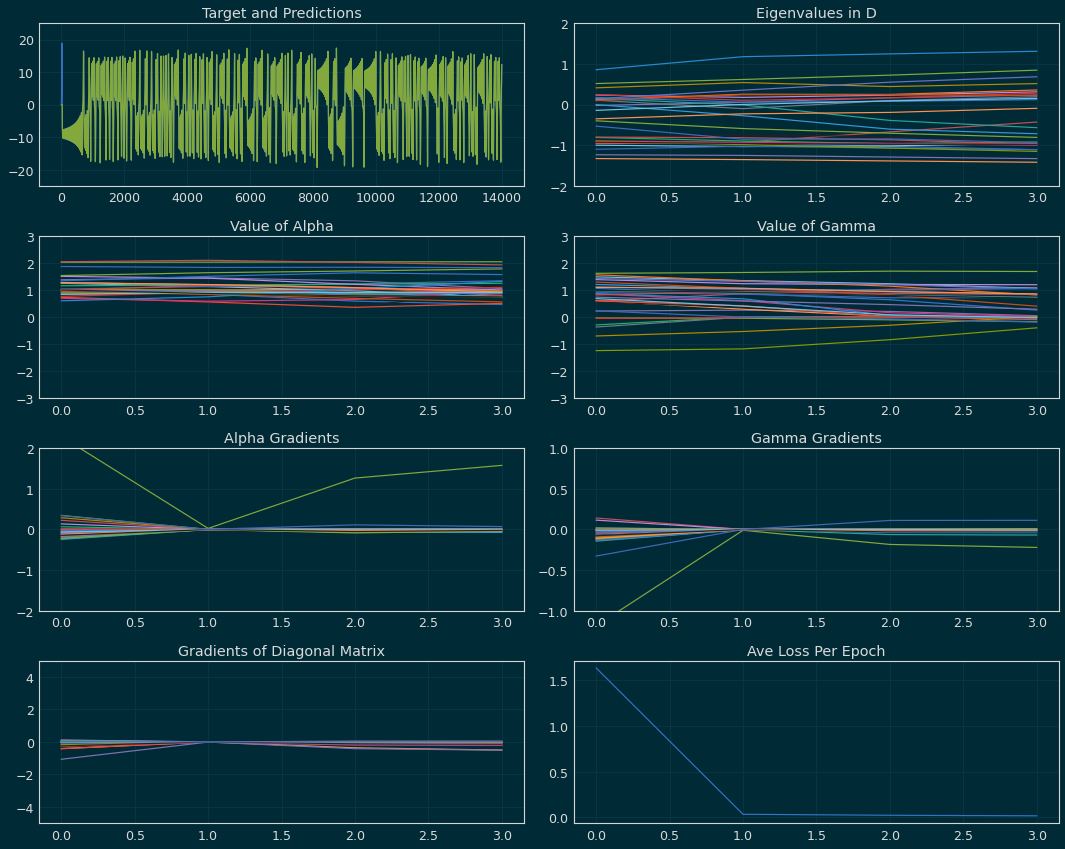

In [11]:
plt.figure(figsize=(15,12))
ax1 = plt.subplot(421)
ax1.set_title('Target and Predictions')
ax1.plot(target, label='tar')
ax1.plot(preds, label='pred')
ax1.set_ylim(-25,25)
#ax1.legend(loc='upper right')

ax2 = plt.subplot(422)
ax2.set_title('Eigenvalues in D')
for i in range(eigs.shape[1]):
    ax2.plot(eigs[:,i],label=f'eig{i}')
ax2.set_ylim(-2,2)
#ax.legend(loc='upper right')

ax3 = plt.subplot(423)
ax3.set_title('Value of Alpha')
for i in range(alphas.shape[1]):
    ax3.plot(alphas[:,i], label=f'alpha{i}')
ax3.set_ylim(-3,3)
#ax3.legend(loc='upper right',ncol=2)

ax4 = plt.subplot(424)
ax4.set_title('Value of Gamma')
for i in range(gammas.shape[1]):
    ax4.plot(gammas [:,i], label=f'gamma{i}')
ax4.set_ylim(-3,3)
#ax4.legend(loc='upper right',ncol=2)

ax5 = plt.subplot(425)
ax5.set_title('Alpha Gradients')
for i in range(Agrad.shape[1]):
    ax5.plot(Agrad[:,i], label=f'A{i}')
ax5.set_ylim(-2,2)
#ax5.legend(loc='upper right')

ax6 = plt.subplot(426)
ax6.set_title('Gamma Gradients')
for i in range(Ggrad.shape[1]):
    ax6.plot(Ggrad[:,i], label=f'G{i}')
ax6.set_ylim(-1,1)
#ax4.legend(loc='upper right')


ax7 = plt.subplot(427)
ax7.set_title('Gradients of Diagonal Matrix')
for i in range(SRgrad.shape[1]):
    ax7.plot(SRgrad[:,i], label=f'SR{i}')
ax7.set_ylim(-5,5)
#plt.legend(loc='upper right')

ax8 = plt.subplot(428)
ax8.set_title('Ave Loss Per Epoch')
ax8.plot(epoch_loss, label=f'ave loss')
plt.tight_layout()
plt.show()
plt.close()

In [5]:
#torch.save({'model' : esn.state_dict(),
#            'Qmat' : esn.Q},
#           './Data/SavedModels/AD3')
esn_dict = torch.load('./Data/SavedModels/AD3')

In [6]:
esn_dict.keys()

dict_keys(['model', 'Qmat'])

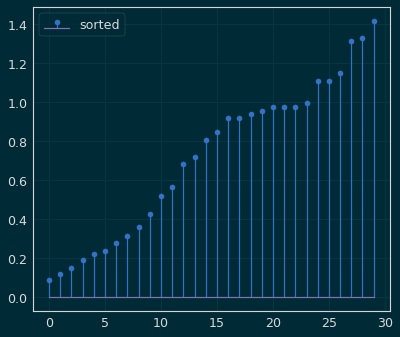

In [7]:
eigenvalues = esn_dict['model']['D'].cpu().numpy()
eigsorted = np.argsort(np.abs(eigenvalues))
plt.stem(np.abs(eigenvalues[eigsorted]), label='sorted')
plt.legend()
plt.show()

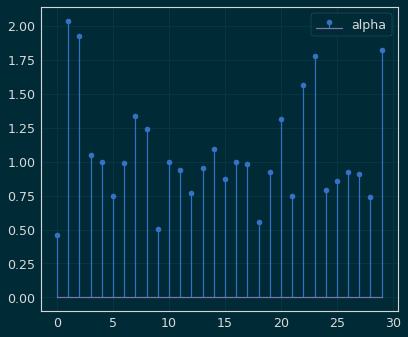

In [10]:
Alphas = esn_dict['model']['Lky.a'].detach().cpu().numpy()
plt.stem(np.squeeze(Alphas), label='alpha')
plt.legend()
plt.show()

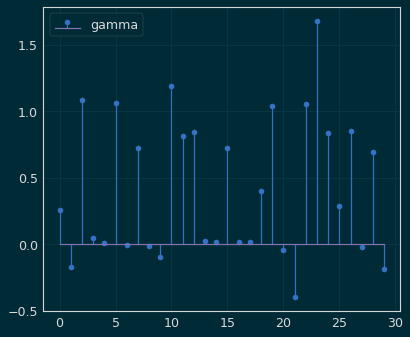

In [11]:
Gammas = esn_dict['model']['Lky.g'].detach().cpu().numpy()
plt.stem(np.squeeze(Gammas), label='gamma')
plt.legend()
plt.show()

In [8]:
D = np.diag(eigenvalues)
Q = esn_dict['Qmat'].detach().cpu().numpy()
Qt = np.transpose(Q)
Wr = np.dot(Q,np.dot(D,Qt))

In [12]:
Wi = esn_dict['model']['Rin.weight'].detach().cpu().numpy()
A = rca.leaky_jacobian(np.zeros((N,K)), np.zeros((K,K)), Alphas.T, Gammas.T, Wi, Wr)
B = rca.partial_u(np.zeros((N,K)), np.zeros((K,K)), Alphas.T, Gammas.T, Wi, Wr)
Cn = rca.reachable_matrix(A,B)
Cn = Cn/np.max(np.abs(rca.eig_spectrum(Cn)))

In [27]:
def rank_curve(Mat, tols):
    return rca.rank(Mat,tols) 

def rank_max_grad(curve):
    return np.argmax(np.gradient(curve))

tolerances = [1/10**x for x in range(0,20)]
ranks = rank_curve(Cn,tolerances)
idx = rank_max_grad(ranks)
print(f'Ave rank for largest gradient {(ranks[idx]+ranks[idx])/2}')

Ave rank for largest gradient 22.0


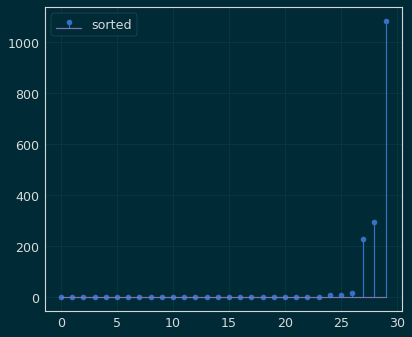

In [16]:
plt.stem(eigenvalues[eigsorted]**20, label='sorted')
plt.legend()
plt.show()

In [17]:
rca.eig_spectrum(A)

array([-2.25762888+0.j        , -1.49250807+0.j        ,
       -1.06810934+0.25093624j, -1.06810934-0.25093624j,
        0.75818492+0.j        , -0.63933751+0.19721127j,
       -0.63933751-0.19721127j, -0.65309896+0.j        ,
        0.48729909+0.00285457j,  0.48729909-0.00285457j,
        0.46276613+0.j        , -0.49565882+0.j        ,
       -0.38861333+0.j        ,  0.26710251+0.02855671j,
        0.26710251-0.02855671j,  0.20105712+0.j        ,
       -0.27880234+0.j        , -0.21658214+0.01444073j,
       -0.21658214-0.01444073j, -0.17662338+0.j        ,
        0.10354059+0.00993365j,  0.10354059-0.00993365j,
       -0.09576891+0.j        , -0.0703396 +0.j        ,
       -0.05329207+0.j        ,  0.04405684+0.j        ,
        0.0307846 +0.j        , -0.00868876+0.j        ,
        0.00795783+0.j        ,  0.00379317+0.j        ])